# Continuity Equation with Fourier Transform


In this notebook, we implement the numerical solver of the continuity equation
$\begin{equation}\frac{\partial \rho}{\partial t} + \frac{\partial (\rho v)}{\partial x} = 0 \end{equation} \tag*{}$
 on $(t,x)\in [0,1]\times [0,L]$ for a given $v:[0,1]\times [0,L]\to \mathbb{R}$ with a periodic boundary using the discrete Fourier transform. In addition, we implement the calculation of the Wasserstein energy consistent with this method. This notebook is available at https://github.com/mao1756/pdot.

In [9]:
# Import relevant libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from typing import Tuple, List

# The Fourier Method and Discretization (Preliminaries)
We solve the equation using the **Fourier coefficient**: 
\begin{equation}
    \hat{u}[k] = \frac{1}{L}\int_{0}^{L}u(x)e^{-i2\pi kx/L} \tag*{}
\end{equation} 
where $k$ is an integer and $u$ is a (nice enough) real function defined on $[0,L]$.

By calculating the Fourier coefficient on both sides of the continuity equation, we obtain
\begin{equation}
    \partial_{t} \hat{\rho}(t,k) +ik \hat{\rho v}(t,k) = 0
\end{equation}
By discretizing the time variable as $t_i=n\Delta t, i=0,\cdots N_0$ where $\Delta t = 1/N_0$ and $N_0$ is the number of time steps, the Forward Euler method gives us the update rule:
\begin{equation}
     \hat{\rho}(t_{n+1},k) = \hat{\rho}(t_n, k) - \Delta tik \hat{\rho v}(t_n,k)
\end{equation}
for all $n=0,\cdots , N$ and $k\in \mathbb{Z}$.

What's left is to discretize the Fourier coefficient. Define the discretization of space variable as $x_j = j\Delta x, j=0,\cdots , N_1-1$ where $\Delta x = L/N_1$ and $N_1$ is the number of space steps. We do not have to include the case $j=N_1$ because of our periodicity assumption. Then the Fourier integral above can be approximated as 

\begin{align}
    \hat{u}[k] &\sim \frac{1}{L}\sum_{j=0}^{N_1-1}u(x_j)e^{-i 2\pi k x_j/L} \Delta x \tag*{} \\
    &= \frac{1}{L}\sum_{j=0}^{N_1-1}u(x_j)e^{-i 2\pi k jL/LN_1} \frac{L}{N_1} \nonumber \\ 
    &=\frac{1}{N_1}\sum_{j=0}^{N_1-1}u(x_j)e^{-i 2\pi k j/N_1} \nonumber
\end{align}
This is exactly what is known as the **Discrete Fourier Transform**(DFT) of the sequence $[u(x_0),\cdots u(x_{N-1})]$. From now on, we refer to $\hat{u}[k]$ as the corresponding DFT, and not the Fourier coefficient integral.
We can now asssume that $k$ is restricted to $k=0,1,\cdots N_1-1$ because $\hat{u}[k+N_1] =\hat{u}[k]$ by the periodicity of exponential functions. 
By periodicity, when $N_1$ is even, $k=-N_1/2+1\cdots N_1/2$ is also an admissible indexing because this amounts to shifting the indexes by $N_1/2$, which still contains the same information. Moreover, in our specific context, this indexing is the only acceptable one. This is because $\hat{\rho}(t_n,k) $ is a Fourier coefficient of a real function $\rho(t_n,x)$, so the Fourier coefficeint must satisfy the Hermitian condition: $\hat{\rho}(t_{n},-k)  = \overline{\hat{\rho}(t_n,k)}$. However, if we use the indexing $k=0,\cdots ,N_1-1$, the update rule by the Euler method breaks this condition. 

From now on, we assume that $N_1$ is even.

As commonly known, given the DFT sequence $[\hat{u}[0],\cdots \hat{u}[N_1/2], \hat{u}[-N_1/2+1],\cdots ,\hat{u}[-1]]$ (This ordering is what is used in numpy), we can recover the original sequence $[u(x_0),\cdots u(x_{N-1})]$ by the **Inverse DFT**:
\begin{align}
    u[j]:= \sum_{k=-N_1/2+1}^{N_1/2}\hat{u}[k]e^{i 2\pi k j/N_1}  \tag*{} \\
\end{align}

We now calculate the $\hat{\rho v}$ in terms of $\hat{\rho}$ and $\hat{v}$ so that calculation is contained in the Fourier space. 
Define the **periodic convolution** by 
\begin{align}
\hat{\rho}*\hat{v}[k] &:= \sum_{k'=-N_1/2+1}^{N_1/2}\hat{\rho}[k']\hat{v}[k-k'] \nonumber \\
&= \sum_{k'=-N_1/2+1}^{N_1/2}\hat{\rho}[k']\left(\frac{1}{N_1}\sum_{j=0}^{N_1-1}v(x_j)e^{-i 2\pi (k-k') j/N_1}\right) \nonumber \\
&= \frac{1}{N_1}\sum_{j=0}^{N_1-1}\left(\sum_{k'=-N_1/2+1}^{N_1/2}\hat{\rho}[k']e^{i 2\pi k' j/N_1}\right)v(x_j)e^{-i 2\pi k j/N_1} \nonumber\\
&= \frac{1}{N_1}\sum_{j=0}^{N_1-1}\rho(x_j)v(x_j)e^{-i 2\pi k j/N_1} \nonumber \\
&= \hat{\rho v}[k] \nonumber
\end{align}
Therefore $\hat{\rho v}$ can be calculted by $\hat{\rho}*\hat{v}$. Moreover, the periodic convolution can be quickly calculated by using FFT.


In [10]:
"""
Utility Codes
"""

def turn_real(input: np.ndarray) -> np.ndarray:
    """
    Given a complex array, it gives a corresponding real array with 
    additional dimension of size 2 such that the first component is real parts and the second is imaginary parts. 
    Args:
        input: a complex numpy array.
    Returns:
        output: A real array corresponding to the input.
    """
    # check if the tensor is complex
    assert input.is_complex(), "Input tensor should be complex"
    
    # separate the real and imaginary parts and stack them along a new dimension
    real_part = input.real
    imag_part = input.imag
    return np.stack((real_part, imag_part), -1)

def turn_complex(input: np.ndarray) -> np.ndarray:
    """
    Inverse of turn_real. The last dimension should have two components.
    """
    # check the last dimension to make sure it has size 2
    assert input.shape[-1] == 2, "The last dimension should have exactly 2 components"
    
    # separate the real and imaginary parts and combine them into a complex tensor
    real_part = input[..., 0]
    imag_part = input[..., 1]
    return np.array(real_part + 1j * imag_part, dtype=np.complex128)

def rfftn_recover(input: np.ndarray, s : List[int] = None, axes : Tuple = None) -> np.ndarray:
    """
    Given a N-D FFT array produced from np.rfftn (only have nonnegative frequencies),
    we recover the full array, starting from the nonnegative freq and then negative freq
    
    Args:
        input: an output of np.rfftn
        s: s used for np.rfftn. This would be the size for transformed axes.
        If not specified, use 2*(input.shape[-1]-1) as the shape of the last axis in axes
        axes: axes used for np.rfftn
    """
    # check if the tensor is complex
    assert np.iscomplexobj(input), "Input tensor should be complex"

    if axes == None: axes = range(len(input.shape))
    if s== None: s=[*input.shape[:-1], 2*(input.shape[-1]-1)]
    
    # Recover the size
    full_shape = [s[i] if i in axes else input.shape[i] for i in range(input.ndim)]
    full_arr = np.empty(full_shape, dtype = input.dtype)

    # Fill the nonnegative part. slice(None) corresponds to : as an index
    slices = [slice(input.shape[i]) if i == axes[-1] else slice(None) for i in range(input.ndim)]
    full_arr[tuple(slices)] = input

    # Fill the negative part. None,None,-1 means going backward
    slices_full = [slice(input.shape[i], s[i]) if i == axes[-1] 
                   else slice(None) for i in range(input.ndim)]
    slices_input = [slice(1,-1,None) if i == axes[-1]
        else slice(None) for i in range(input.ndim)]
    
    # Since flip() starts from -1, roll to start from 0
    axes_notlast = [element for element in axes if element!=axes[-1]]
    full_arr[tuple(slices_full)] = np.roll(np.flip(input.conj()[tuple(slices_input)], axes), 1, axes_notlast)
    return full_arr

"""
Base Codes
"""

class FVar():
    """Fourier Variable.
    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the space or L (list of L's if higher dimension)
    phat(N_0+1*N_1 ... *(N_D//2+1) array): Fouriermass on the centered grid
    vhat(N_0+1*N_1 ... *(N_D//2+1)*D array): Fourier velocity on the centered grid
    """
    def __init__(self,
                 cs : List[int],
                 ll : List[float]):         
        self.cs = cs
        self.ll = ll
        space_dimension = len(self.cs)-1
        size = [cs[0]+1, *cs[1:]]
        self.phat = np.fft.rfftn(np.zeros(size), axes=tuple(range(1, space_dimension+1)))
        self.vhat = np.fft.rfftn(np.zeros(size+[space_dimension]), axes=tuple(range(1, space_dimension+1)))

class FourierTransportEquation():
    """ The Transport Equation Solver Using Fourier Transport

    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the time/space or L (list of L's if higher dimension)
    L0 = total time, L1 = length of the first space dimension, ...
    var: the variables on the centered grid
    """

    def __init__(self,
                 cs: List[int],
                 ll: List[int],
                 p0: np.ndarray,
                 v: np.ndarray):
        """
        Args:
            p0: initial density
            v: real velocity field
            k: the grid on the fourier space with the sum of corresponding wave number k 
        """
        self.cs = cs
        self.ll = ll
        self.var = FVar(cs, ll)
        self.dt = 1./self.cs[0]
        self.dx = np.array(self.ll[1:])/np.array(self.cs[1:])
        
        self.space_dim = len(self.cs)-1
        self.var.phat[0] = np.fft.rfftn(p0)
        self.var.vhat = np.fft.rfftn(v, axes = tuple(range(1,self.space_dim+1)))

        self.k_coordinates = [np.fft.fftfreq(self.cs[i], 1/self.cs[i]) for i in range(1, self.space_dim+1)]

    def interp_time(self, t: float, vhat: np.ndarray):
        """
        Given the discretized time dependent Fourier vector field, it returns the field at time t.
        Args:
            t: the time
            vhat: N_0*N_1*...*(N_D//2+1)*D 

        """

    def _ivp_func(self, t: float, phat: np.ndarray, vhat:np.ndarray):
        """
        Evaluates the time derivative of phat given phat and vhat at that time.
        Args:
            t : the time variable
            phat : N_1*...*(N_D//2+1) array of Fourier density at time t (rfftn format)
            vhat : N_1*...*(N_D//2+1)*D arary of Fourier velocity at time t (rfftn format)
        Returns:
            time_der : time derivative of phat
        """
        #Calculate the periodic convolution by PeriodiConv(f,g) = IDFT(DFT(f)Dft(g))
        recovered_phat = rfftn_recover(phat, self.cs[1:]) 
        recovered_vhat = rfftn_recover(vhat, self.cs[1:], tuple(range(self.space_dim)))
        fft_product = np.fft.fftn(recovered_phat).reshape(-1,1)*np.fft.fftn(recovered_vhat, axes=tuple(range(self.space_dim)))
        periodic_conv = np.fft.ifftn(fft_product, axes=tuple(range(self.space_dim)))
        
        # Find the slicing so that the size of periodic_conv matches to the rfftn format
        slices = [slice(0, self.cs[-1]//2+1) if i == self.space_dim-1 else slice(None) for i in range(self.space_dim)]
        return sum(-1.j*self.k_coordinates[i]*periodic_conv[...,i] for i in range(self.space_dim))[tuple(slices)]
    
    def solve(self):
        return solve_ivp(self._ivp_func,(0,1),
                         self.var.phat[0],
                         args=(self.var.vhat[0],),
                         t_eval = np.linspace(0, 1, self.cs[0]+1, endpoint = True),
                         method='RK23')

    def solve_euler(self):
        for i0 in range(self.cs[0]):
            #Calculate the periodic convolution by PeriodiConv(f,g) = IDFT(DFT(f)Dft(g))
            recovered_phat = rfftn_recover(self.var.phat[i0], self.cs[1:]) 
            recovered_vhat = rfftn_recover(self.var.vhat[i0], self.cs[1:], tuple(range(self.space_dim)))
            fft_product = np.fft.fftn(recovered_phat).reshape(-1,1)*np.fft.fftn(recovered_vhat, axes=tuple(range(self.space_dim)))
            periodic_conv = np.fft.ifftn(fft_product, axes=tuple(range(self.space_dim)))
            # Find the slicing so that the size of periodic_conv matches to the rfftn format
            slices = [slice(0, self.cs[-1]//2+1) if i == self.space_dim-1 else slice(None) for i in range(self.space_dim)]
            self.var.phat[i0+1] = self.var.phat[i0] + self.dt*sum(-1.j*self.k_coordinates[i]*periodic_conv[...,i]/self.dx[i] for i in range(self.space_dim))[tuple(slices)]

In [15]:
random = np.random.randn(100)
four = np.fft.fftn(random)
rf = rfftn_recover(np.fft.rfftn(random))
np.abs(four-rf).max()

1.7112135109858138e-13

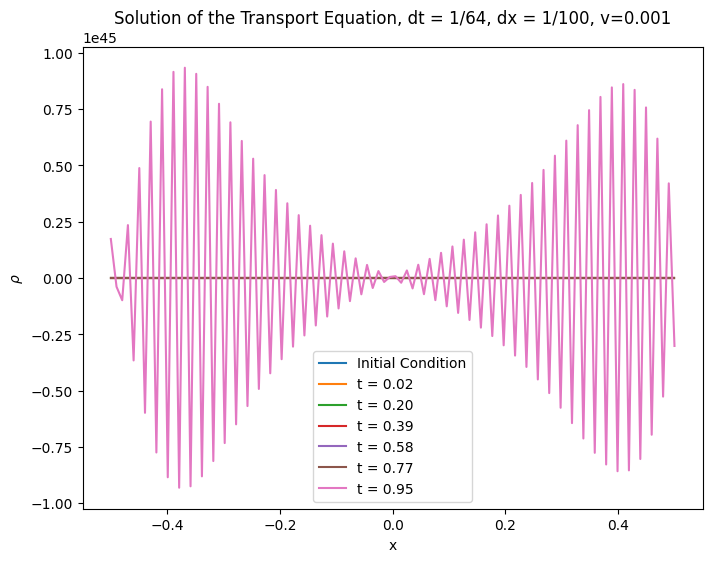

In [28]:
# Setting up the problem
cs = [64, 100]  # [time steps, spatial points]
ll = [1.0, 1.0]  # [total time, spatial domain size]
x = np.linspace(-ll[1]/2, ll[1]/2, cs[1])
size = [cs[0]+1, *cs[1:]]
p0 = np.exp(-50*x**2)
velocity=0.001
v = velocity*np.ones(size+[1])

# Create a TransportEquation instance
transport_eq = FourierTransportEquation(cs, ll, p0, v)
# Solve the transport equation
#p = transport_eq.solve()
#preal = [np.fft.ifftn(rfftn_recover(p.y[...,i], cs[1:])) for i in range(p.y.shape[1])]

transport_eq.solve_euler()
preal = [np.fft.ifftn(rfftn_recover(transport_eq.var.phat[i], cs[1:])) for i in range(cs[0]+1)]

# Visualization
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, p0, label="Initial Condition")
for i in range(1, cs[0]+1, cs[0]//5):
    ax.plot(x, preal[i], label=f"t = {i/cs[0]:.2f}")

ax.set_title(f"Solution of the Transport Equation, dt = 1/{cs[0]}, dx = 1/{cs[1]}, v={velocity}")
ax.set_xlabel("x")
ax.set_ylabel(r"$\rho$")
ax.legend()
plt.show()

We now implement it using PyTorch.

In [18]:
import torch
import torchdiffeq
import matplotlib.pyplot as plt
from typing import Tuple, List

In [45]:
"""
Utility Codes
"""

def turn_real(input: torch.Tensor) -> torch.Tensor:
    """
    Given a complex array, it gives a corresponding real array with 
    additional dimension of size 2 such that the first component is real parts and the second is imaginary parts. 
    Args:
        input: a complex numpy array.
    Returns:
        output: A real array corresponding to the input.
    """
    # check if the tensor is complex
    assert input.is_complex(), "Input tensor should be complex"
    
    # separate the real and imaginary parts and stack them along a new dimension
    real_part = input.real
    imag_part = input.imag
    return torch.stack((real_part, imag_part), -1)

def turn_complex(input: torch.Tensor) -> torch.Tensor:
    """
    Inverse of turn_real. The last dimension should have two components.
    """
    # check the last dimension to make sure it has size 2
    assert input.shape[-1] == 2, "The last dimension should have exactly 2 components"
    
    # separate the real and imaginary parts and combine them into a complex tensor
    real_part = input[..., 0]
    imag_part = input[..., 1]
    return torch.complex(real_part, imag_part)

def rfftn_recover(input: torch.Tensor, s : List[int] = None, axes : Tuple = None) -> torch.Tensor:
    """
    Given a N-D FFT array produced from np.rfftn (only have nonnegative frequencies),
    we recover the full array, starting from the nonnegative freq and then negative freq
    
    Args:
        input: an output of np.rfftn
        s: s used for np.rfftn. This would be the size for transformed axes.
        If not specified, use 2*(input.shape[-1]-1) as the shape of the last axis in axes
        axes: axes used for np.rfftn
    """
    # check if the tensor is complex
    assert input.is_complex(), "Input tensor should be complex"

    if axes == None: axes = tuple(range(len(input.shape)))
    if s== None: s=[*input.shape[:-1], 2*(input.shape[-1]-1)]
    
    # Recover the size
    full_shape = [s[i] if i in axes else input.shape[i] for i in range(input.ndim)]
    full_arr = torch.empty(full_shape, dtype = input.dtype)

    # Fill the nonnegative part. slice(None) corresponds to : as an index
    slices = [slice(input.shape[i]) if i == axes[-1] else slice(None) for i in range(input.ndim)]
    full_arr[tuple(slices)] = input

    # Fill the negative part. None,None,-1 means going backward
    slices_full = [slice(input.shape[i], s[i]) if i == axes[-1] 
                   else slice(None) for i in range(input.ndim)]
    # Cut off the first element(the zero frequency) and the last (Nyquist freq)
    slices_input = [slice(1,-1,None) if i == axes[-1]
        else slice(None) for i in range(input.ndim)]
    
    # Since flip() starts from -1, roll to start from 0
    axes_notlast = [element for element in axes if element!=axes[-1]]
    flipped = torch.flip(input.conj()[tuple(slices_input)], axes)
    if axes_notlast: # if not empty
        full_arr[tuple(slices_full)] = torch.roll(flipped, 1, axes_notlast)
    else: # if empty
        full_arr[tuple(slices_full)] = flipped
    return full_arr

"""
Base Codes
"""

class FVar():
    """Fourier Variable.
    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the space or L (list of L's if higher dimension)
    phat(N_0+1*N_1 ... *(N_D//2+1) tensor): Fouriermass on the centered grid
    vhat(N_0+1*N_1 ... *(N_D//2+1)*D tensor): Fourier velocity on the centered grid
    """
    def __init__(self,
                 cs : List[int],
                 ll : List[float]):         
        self.cs = cs
        self.ll = ll
        space_dimension = len(self.cs)-1
        size = [cs[0]+1, *cs[1:]]
        self.phat = torch.fft.rfftn(torch.zeros(size), dim=tuple(range(1, space_dimension+1)))
        self.vhat = torch.fft.rfftn(torch.zeros(size+[space_dimension]), dim=tuple(range(1, space_dimension+1)))

class FourierTransportEquation():
    """ The Transport Equation Solver Using Fourier Transport

    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the time/space or L (list of L's if higher dimension)
    L0 = total time, L1 = length of the first space dimension, ...
    var: the variables on the centered grid
    """

    def __init__(self,
                 cs: List[int],
                 ll: List[int],
                 p0: torch.Tensor,
                 v: torch.Tensor,
                 solver = 'euler'):
        """
        Args:
            p0: initial density
            v: real velocity field
            k: the grid on the fourier space with the sum of corresponding wave number k 
            solver: solver to use in torchdiffeq
        """
        self.cs = cs
        self.ll = ll
        self.var = FVar(cs, ll)
        self.dt = 1./self.cs[0]
        self.dx = torch.Tensor(self.ll[1:])/torch.Tensor(self.cs[1:])
        self.solver = solver

        self.space_dim = len(self.cs)-1
        self.var.phat[0] = torch.fft.rfftn(p0)    
        self.var.vhat = torch.fft.rfftn(v, dim = tuple(range(1,self.space_dim+1)))

        self.k_coordinates = [torch.fft.fftfreq(self.cs[i], 1/self.cs[i]) for i in range(1, self.space_dim+1)]

    def interp_vhat(self, t: float):
        """ Given time t, it returns the field at time t.

        We use the linear interpolation in time to calculate the Fourier vector field vhat when t 
        is not on the time grid.
        We use the formula
            vhat(t, x) = (t-t_i)vhat(t_i, x)/(t_(i+1)-t_i) + (t_(i+1)-t)vhat(t_(i+1), x)/(t_(i+1)-t_i)
        where t_i,t_(i+1) are the adjacent time points on the grid that satisfies t_i < t < t_i+1.

        Args:
            t: the time
        Returns:
            interp: the interpolated vector field
        """

    def _ivp_func(self, t: float, phat: torch.Tensor):
        """
        Evaluates the time derivative of phat given phat and vhat at that time.
        Args:
            t : the time variable
            phat : N_1*...*(N_D//2+1) array of Fourier density at time t (rfftn format)
            vhat : N_1*...*(N_D//2+1)*D arary of Fourier velocity at time t (rfftn format)
        Returns:
            time_der : time derivative of phat
        """
        #Calculate the periodic convolution by PeriodiConv(f,g) = IDFT(DFT(f)Dft(g))
        recovered_phat = rfftn_recover(phat, self.cs[1:]) 
        recovered_vhat = rfftn_recover(self.var.vhat[0], self.cs[1:], tuple(range(self.space_dim)))
        fft_product = torch.fft.fftn(recovered_phat).reshape(-1,1)*torch.fft.fftn(recovered_vhat, dim=tuple(range(self.space_dim)))
        periodic_conv = torch.fft.ifftn(fft_product, dim=tuple(range(self.space_dim)))
        
        # Find the slicing so that the size of periodic_conv matches to the rfftn format
        slices = [slice(0, self.cs[-1]//2+1) if i == self.space_dim-1 else slice(None) for i in range(self.space_dim)]
        return sum(-1.j*self.k_coordinates[i]*periodic_conv[...,i] for i in range(self.space_dim))[tuple(slices)]
    
    def solve(self):
            return torchdiffeq.odeint(self._ivp_func, self.var.phat[0], t=torch.linspace(0, 1, self.cs[0]+1), method=self.solver)

/home/mao1756/.local/lib/python3.8/site-packages/torch/_tensor.py:1032: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


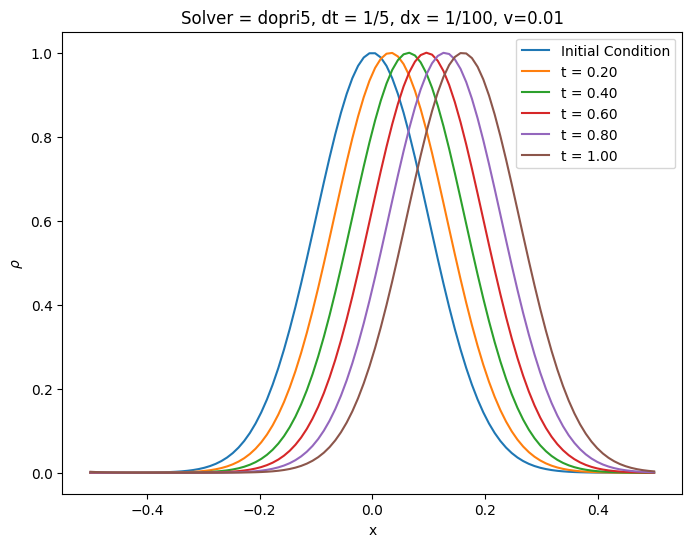

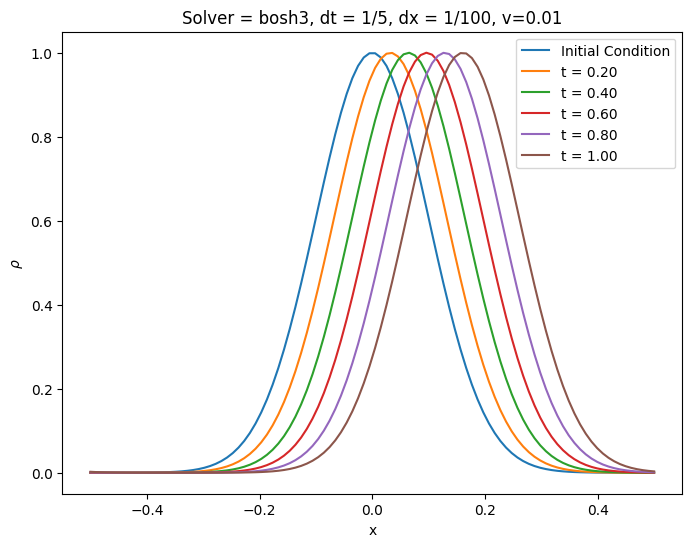

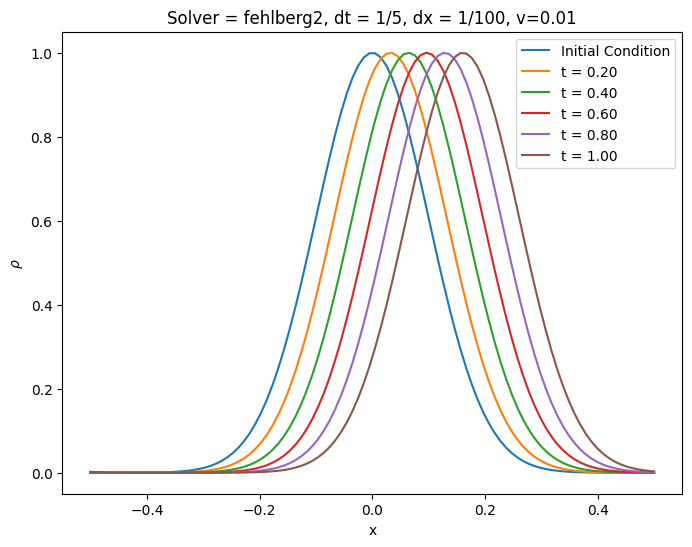

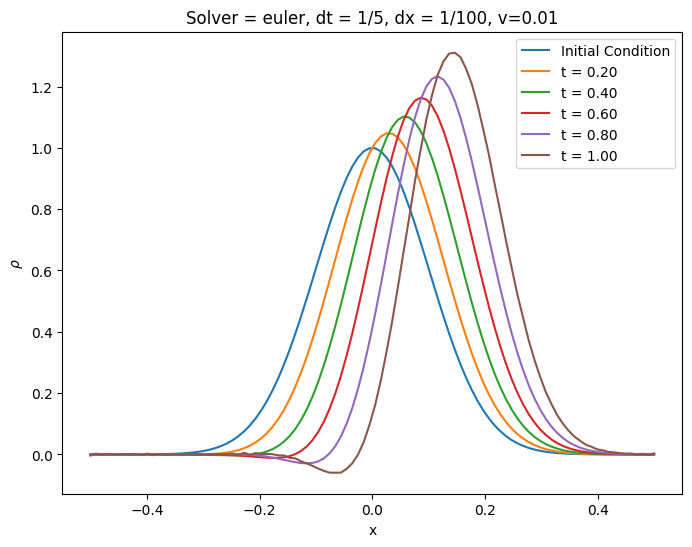

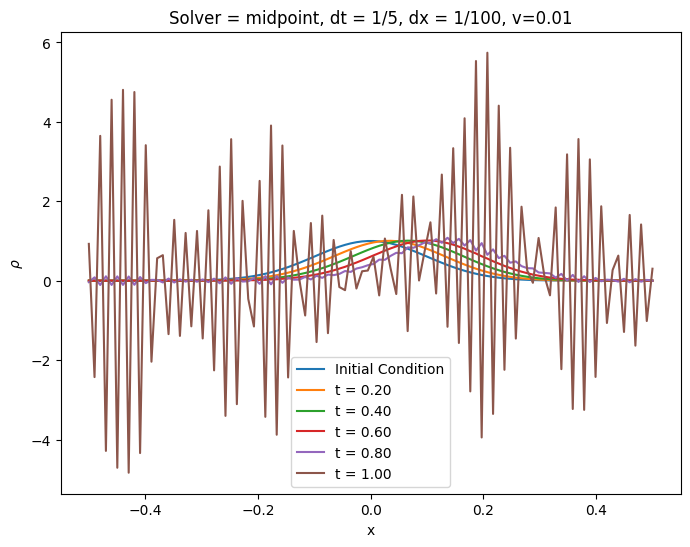

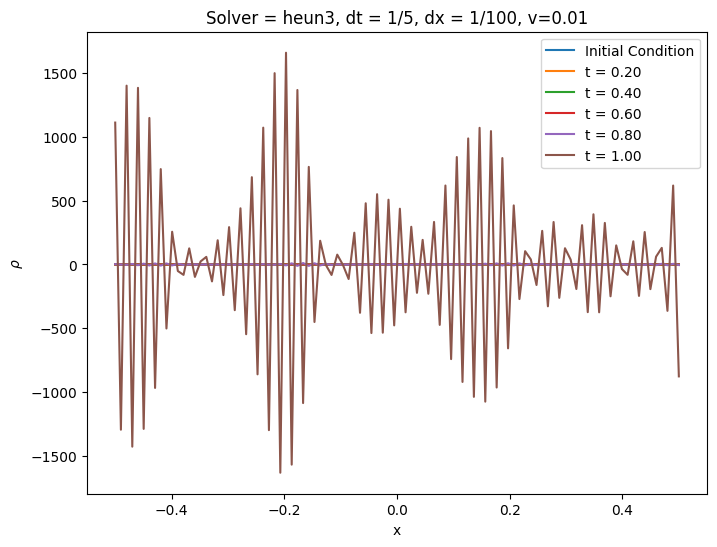

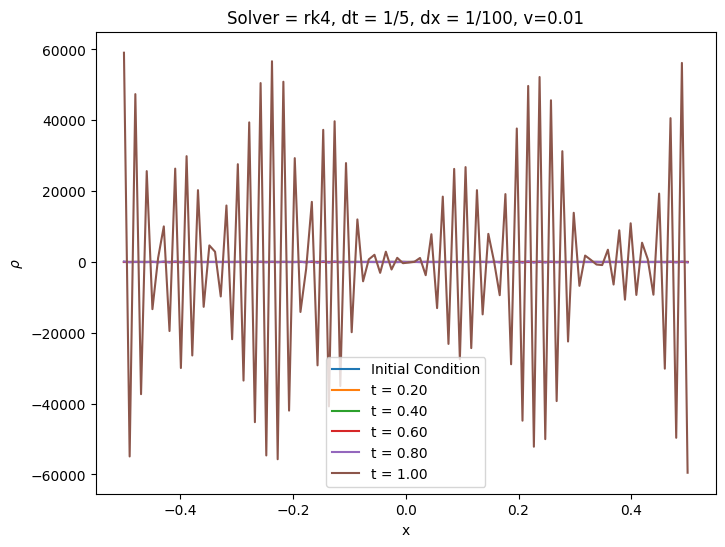

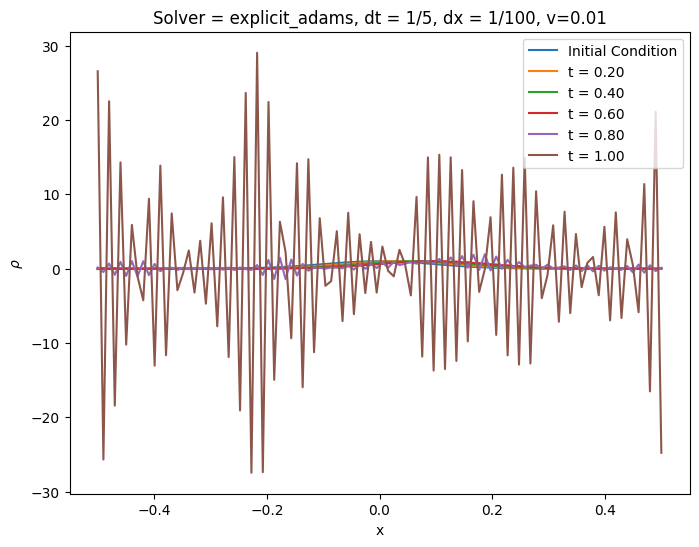

/home/mao1756/.local/lib/python3.8/site-packages/torchdiffeq/_impl/fixed_adams.py:220: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


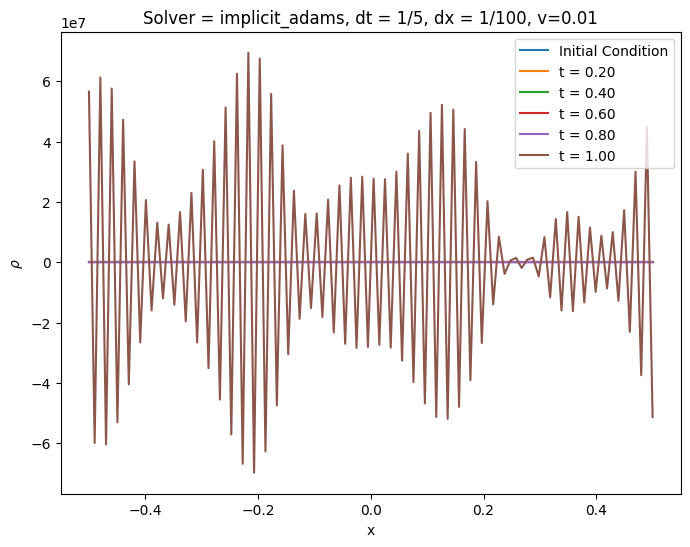

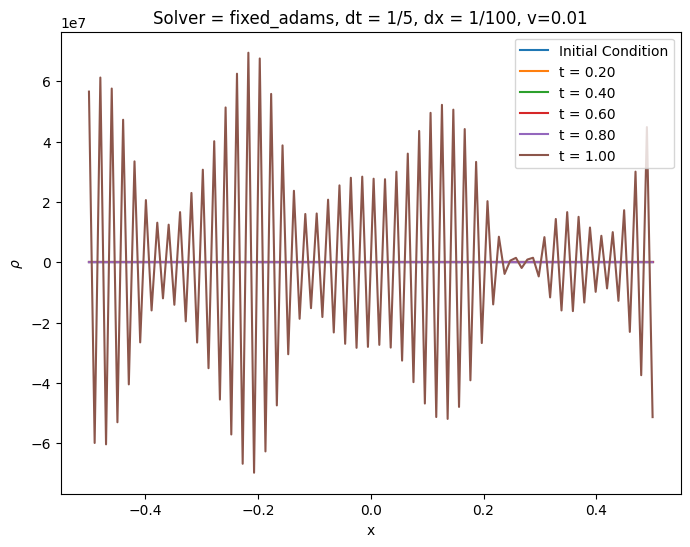

solvers  times (sec)
0          dopri5     8.021384
1           bosh3    14.872629
2       fehlberg2     2.702201
3           euler     0.008290
4        midpoint     0.011063
5           heun3     0.014586
6             rk4     0.014224
7  explicit_adams     0.011331
8  implicit_adams     0.050426
9     fixed_adams     0.054666

In [51]:
import time
import pandas as pd

def plot_solution(x, p0, preal, cs, velocity, solver):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, p0, label="Initial Condition")
    for i in range(1, cs[0]+1, cs[0]//5):
            ax.plot(x, preal[i], label=f"t = {i/cs[0]:.2f}")
    ax.set_title(f"Solver = {solver}, dt = 1/{cs[0]}, dx = 1/{cs[1]}, v={velocity}")
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\rho$")
    ax.legend()
    plt.show()

# Setting up the problem
cs = [5, 100]  # [time steps, spatial points]
ll = [1.0, 1.0]  # [total time, spatial domain size]
x = torch.linspace(-ll[1]/2, ll[1]/2, cs[1])
size = [cs[0]+1, *cs[1:]]
p0 = torch.exp(-50*x**2)
velocity=1/cs[1]
v = velocity*torch.ones(size+[1])

solvers = [#'dopri8',
 'dopri5',
 'bosh3',
 'fehlberg2',
 #'adaptive_heun',
 'euler',
 'midpoint',
 'heun3',
 'rk4',
 'explicit_adams',
 'implicit_adams',
 'fixed_adams']

times = []

for solver in solvers:
      start_time = time.time()
      ftp =  FourierTransportEquation(
            cs,
            ll,
            p0,
            v,
            solver
      )
      p = ftp.solve()
      end_time = time.time()
      #print(f'time elapsed for {solver}: {end_time-start_time}')
      times.append(end_time-start_time)
      preal = [torch.fft.ifftn(rfftn_recover(p[i], cs[1:])) for i in range(cs[0]+1)]
      plot_solution(x, p0, preal, cs, velocity, solver)

table = {
      'solvers': solvers,
      'times (sec)' : times 
}
df = pd.DataFrame(table)
df

/home/mao1756/.local/lib/python3.8/site-packages/torch/_tensor.py:1032: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


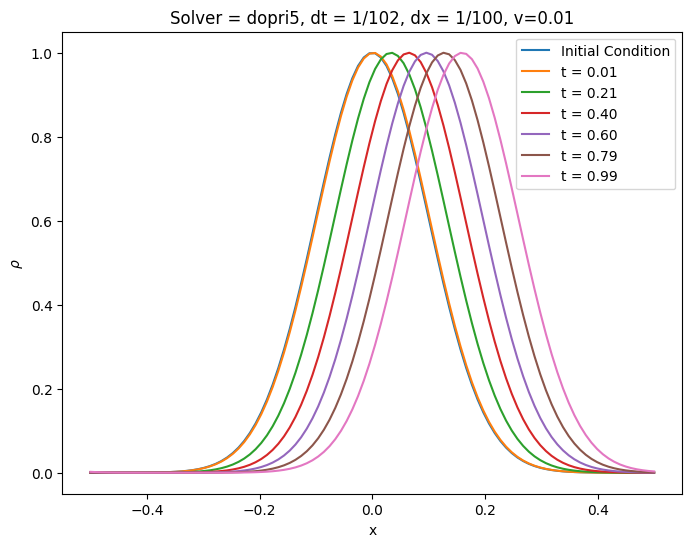

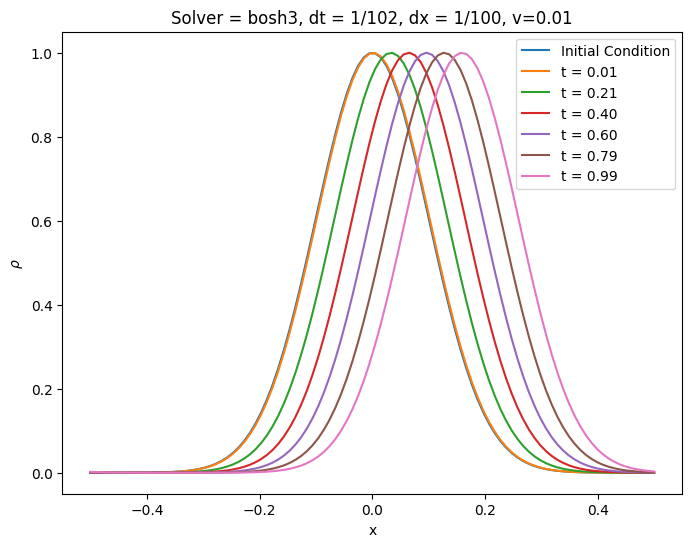

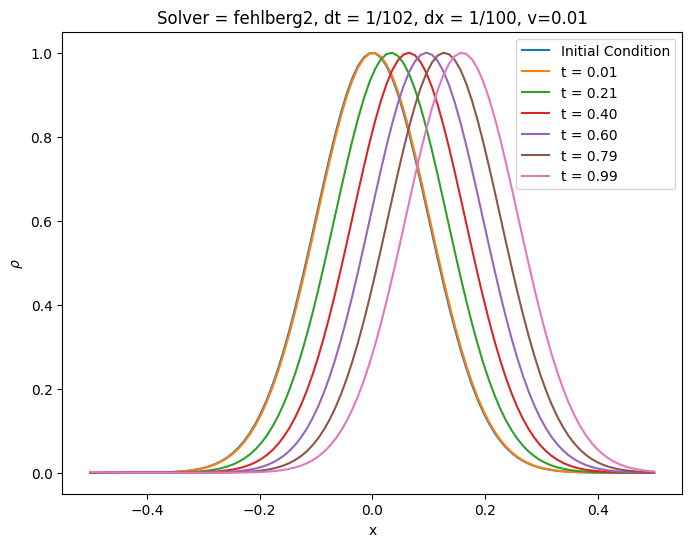

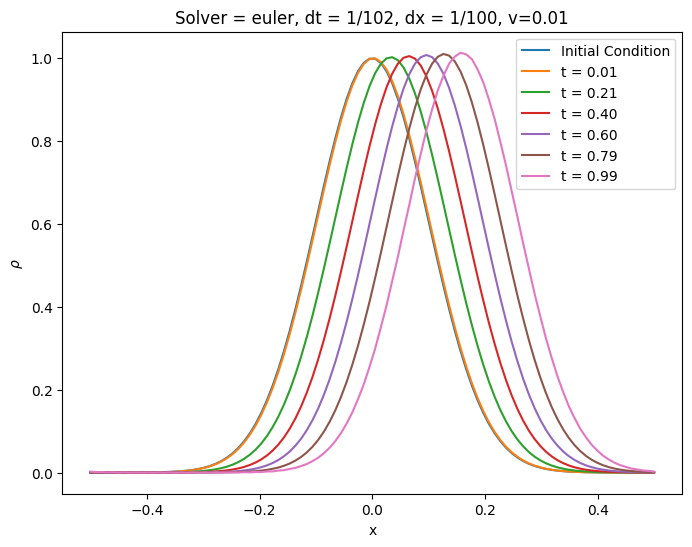

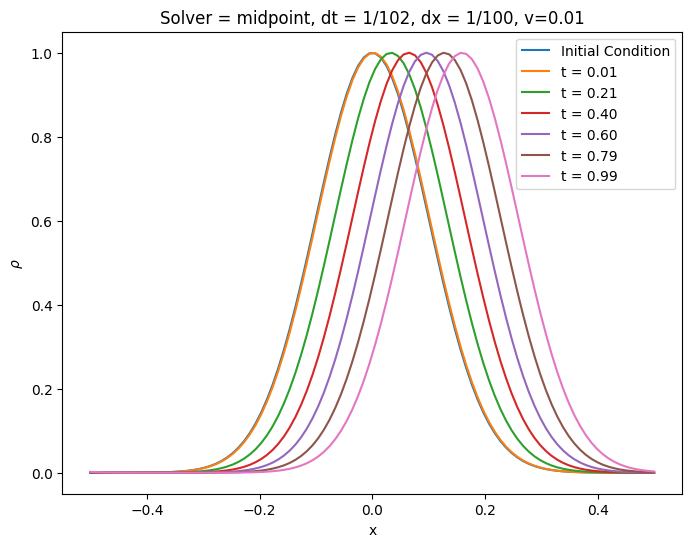

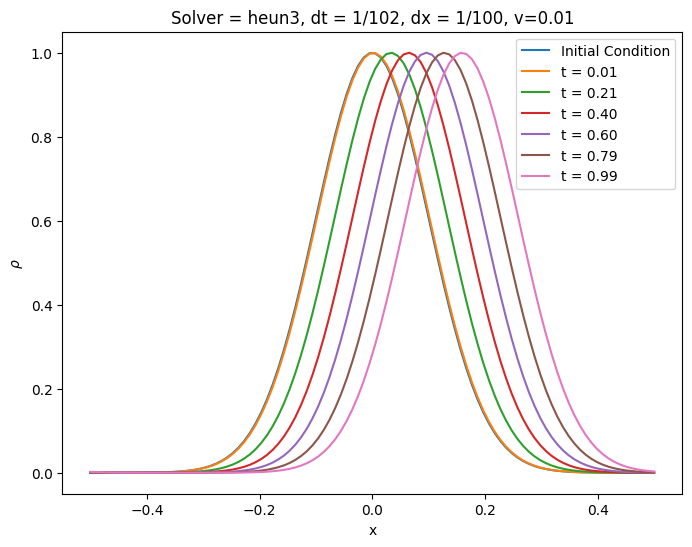

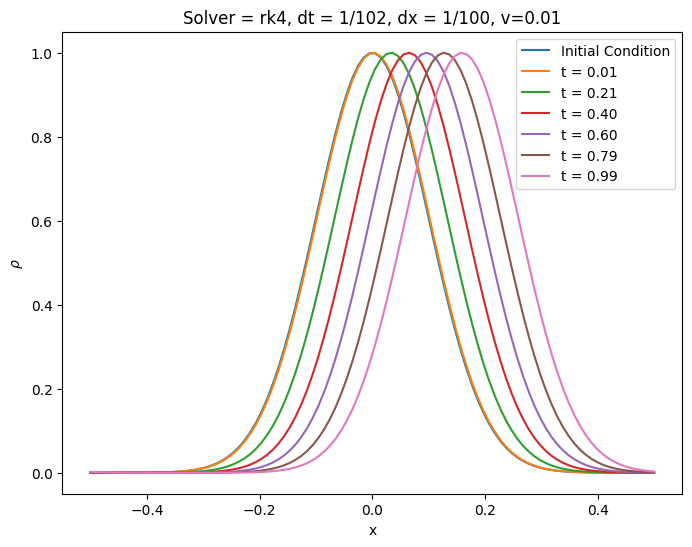

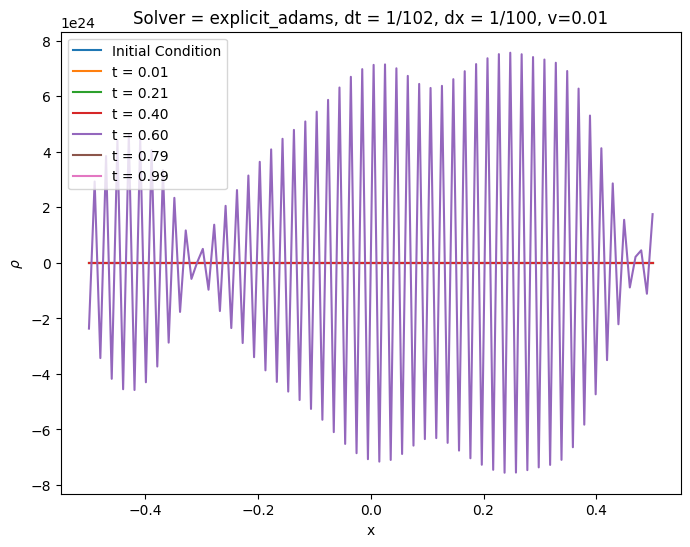

/home/mao1756/.local/lib/python3.8/site-packages/torchdiffeq/_impl/fixed_adams.py:220: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


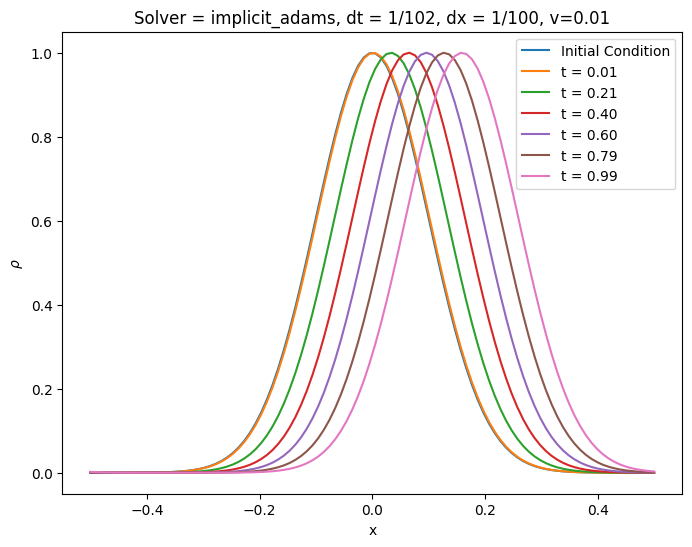

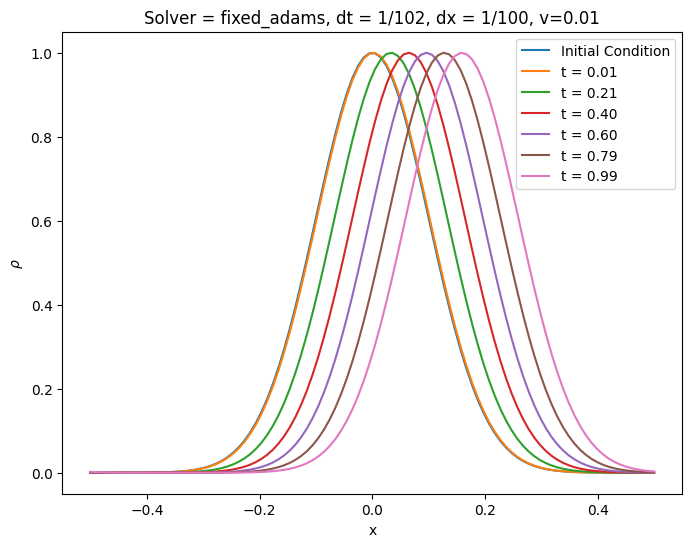

solvers  times (sec)
0          dopri5     9.843171
1           bosh3    20.088480
2       fehlberg2     2.542230
3           euler     0.176751
4        midpoint     0.239513
5           heun3     0.581173
6             rk4     0.988459
7  explicit_adams     0.661405
8  implicit_adams     0.859946
9     fixed_adams     0.839226

In [56]:
import time
import pandas as pd

def plot_solution(x, p0, preal, cs, velocity, solver):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, p0, label="Initial Condition")
    for i in range(1, cs[0]+1, cs[0]//5):
            ax.plot(x, preal[i], label=f"t = {i/cs[0]:.2f}")
    ax.set_title(f"Solver = {solver}, dt = 1/{cs[0]}, dx = 1/{cs[1]}, v={velocity}")
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\rho$")
    ax.legend()
    plt.show()

# Setting up the problem
cs = [102, 100]  # [time steps, spatial points]
ll = [1.0, 1.0]  # [total time, spatial domain size]
x = torch.linspace(-ll[1]/2, ll[1]/2, cs[1])
size = [cs[0]+1, *cs[1:]]
p0 = torch.exp(-50*x**2)
velocity=1/cs[1]
v = velocity*torch.ones(size+[1])

solvers = [#'dopri8',
 'dopri5',
 'bosh3',
 'fehlberg2',
 #'adaptive_heun',
 'euler',
 'midpoint',
 'heun3',
 'rk4',
 'explicit_adams',
 'implicit_adams',
 'fixed_adams']

times = []

for solver in solvers:
      start_time = time.time()
      ftp =  FourierTransportEquation(
            cs,
            ll,
            p0,
            v,
            solver
      )
      p = ftp.solve()
      end_time = time.time()
      #print(f'time elapsed for {solver}: {end_time-start_time}')
      times.append(end_time-start_time)
      preal = [torch.fft.ifftn(rfftn_recover(p[i], cs[1:])) for i in range(cs[0]+1)]
      plot_solution(x, p0, preal, cs, velocity, solver)

table = {
      'solvers': solvers,
      'times (sec)' : times 
}
df = pd.DataFrame(table)
df

/home/mao1756/.local/lib/python3.8/site-packages/torch/_tensor.py:1032: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


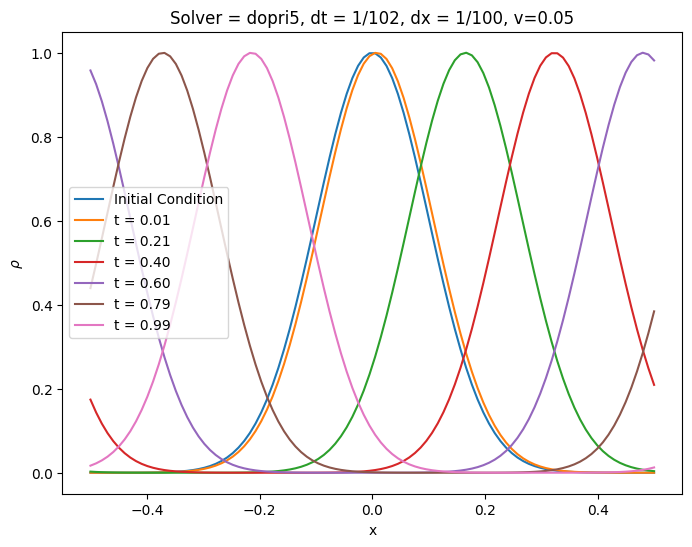

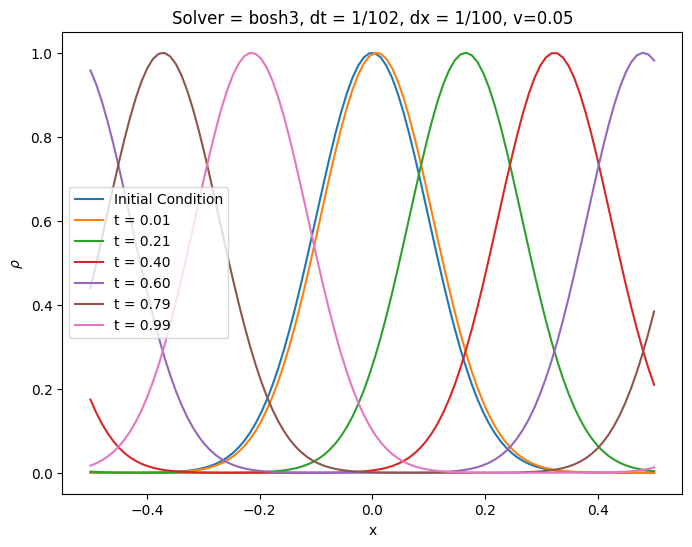

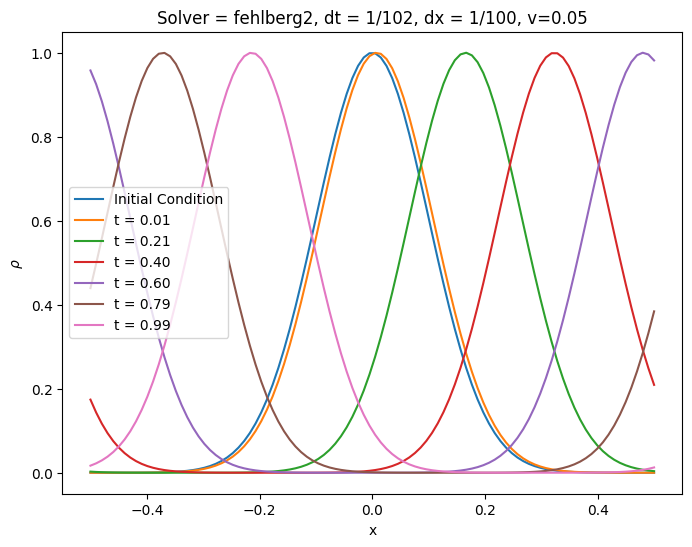

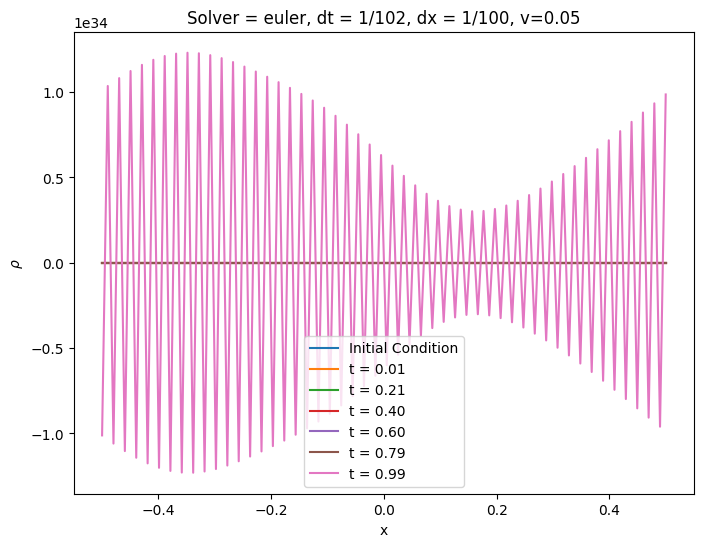

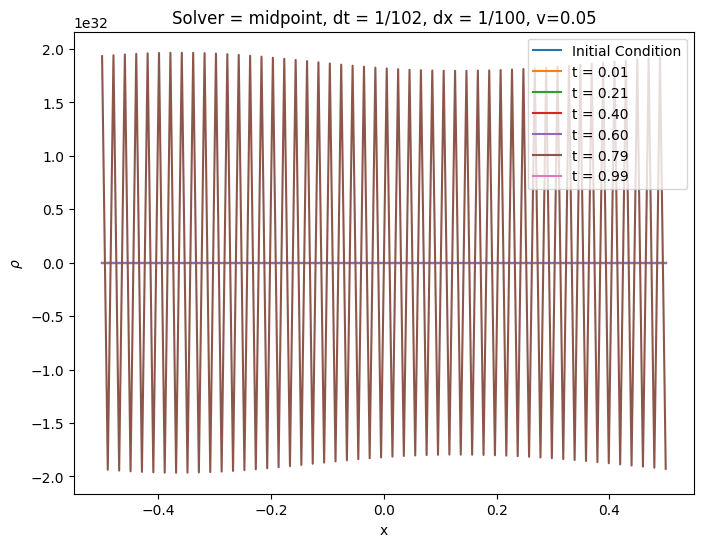

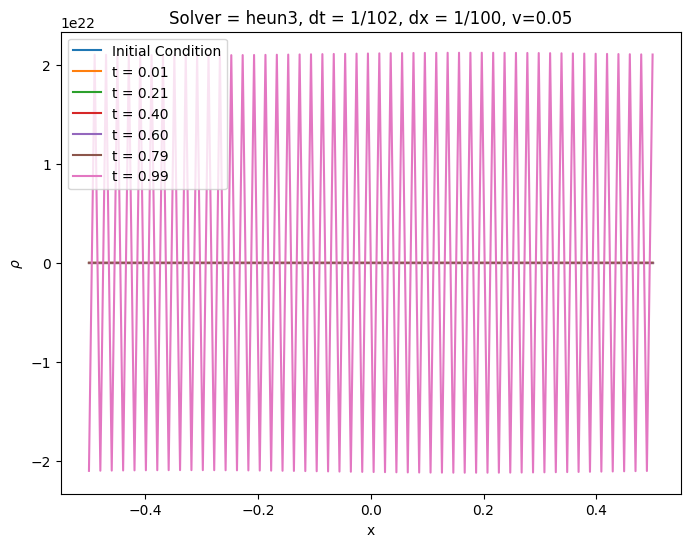

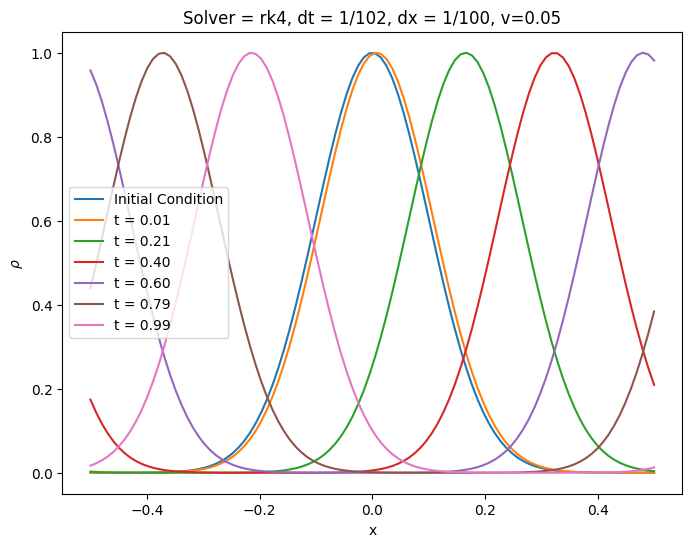

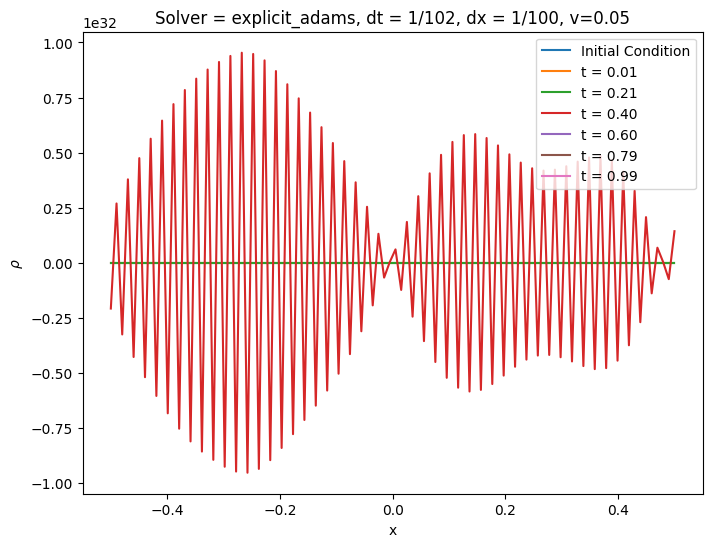

/home/mao1756/.local/lib/python3.8/site-packages/torchdiffeq/_impl/fixed_adams.py:220: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


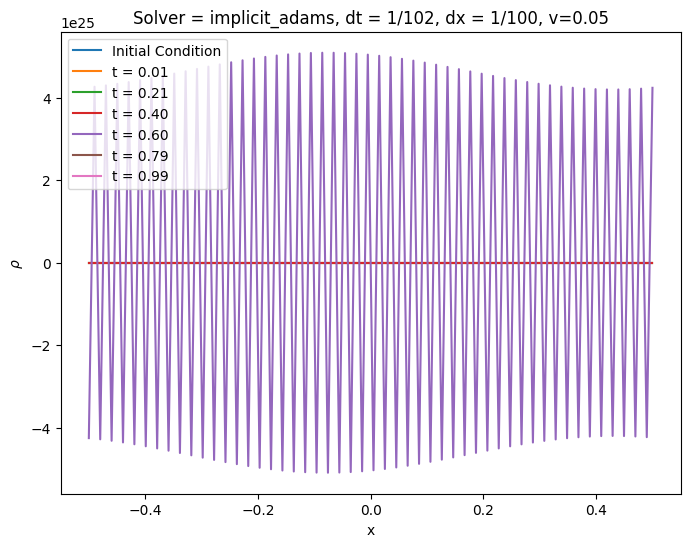

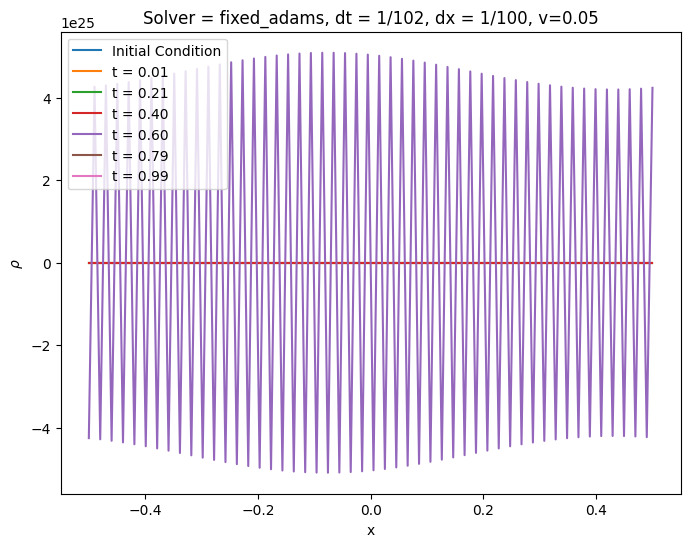

solvers  times (sec)
0          dopri5    63.512706
1           bosh3   105.832713
2       fehlberg2     8.987211
3           euler     0.332178
4        midpoint     0.358219
5           heun3     0.403211
6             rk4     0.664924
7  explicit_adams     0.280901
8  implicit_adams     0.826699
9     fixed_adams     0.621284

In [57]:
import time
import pandas as pd

def plot_solution(x, p0, preal, cs, velocity, solver):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, p0, label="Initial Condition")
    for i in range(1, cs[0]+1, cs[0]//5):
            ax.plot(x, preal[i], label=f"t = {i/cs[0]:.2f}")
    ax.set_title(f"Solver = {solver}, dt = 1/{cs[0]}, dx = 1/{cs[1]}, v={velocity}")
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\rho$")
    ax.legend()
    plt.show()

# Setting up the problem
cs = [102, 100]  # [time steps, spatial points]
ll = [1.0, 1.0]  # [total time, spatial domain size]
x = torch.linspace(-ll[1]/2, ll[1]/2, cs[1])
size = [cs[0]+1, *cs[1:]]
p0 = torch.exp(-50*x**2)
velocity=5/cs[1]
v = velocity*torch.ones(size+[1])

solvers = [#'dopri8',
 'dopri5',
 'bosh3',
 'fehlberg2',
 #'adaptive_heun',
 'euler',
 'midpoint',
 'heun3',
 'rk4',
 'explicit_adams',
 'implicit_adams',
 'fixed_adams']

times = []

for solver in solvers:
      start_time = time.time()
      ftp =  FourierTransportEquation(
            cs,
            ll,
            p0,
            v,
            solver
      )
      p = ftp.solve()
      end_time = time.time()
      #print(f'time elapsed for {solver}: {end_time-start_time}')
      times.append(end_time-start_time)
      preal = [torch.fft.ifftn(rfftn_recover(p[i], cs[1:])) for i in range(cs[0]+1)]
      plot_solution(x, p0, preal, cs, velocity, solver)

table = {
      'solvers': solvers,
      'times (sec)' : times 
}
df = pd.DataFrame(table)
df

# CFL Conditions and Fixed Steps Methods
Two things would lead to divergence: too small time steps and too large velocity, which is consisntent with the CFL condition
$\begin{equation}v_{max} \frac{\Delta t}{\Delta x} < C_{max} \tag*{} \end{equation}$
By numerical experiments, I found that $C_{max}$ seems to be very small for all fixed steps methods.

Numerical experiments showed that the method with the largest $C_{max}$ was rk4 with $C_{max} \sim 0.1$.

Adaptive step methods such as fehlberg2 seems to have no problem with this, but it is much slower than fixed step methods.

0.12


tensor(7.3960e+16)


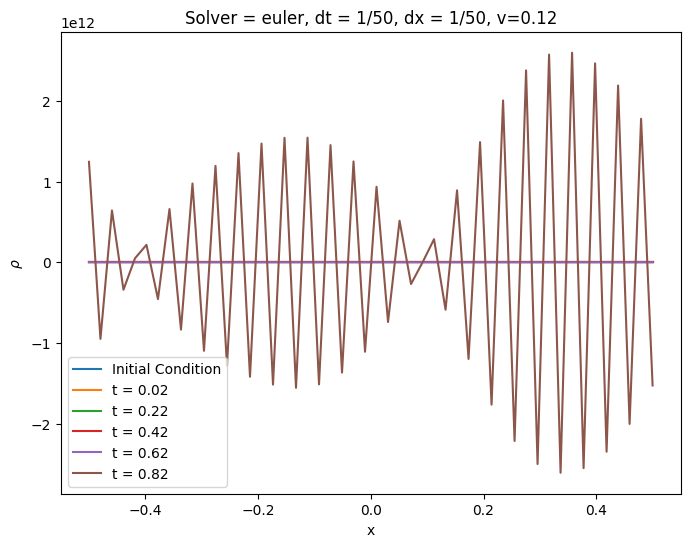

tensor(8.0012e+24)


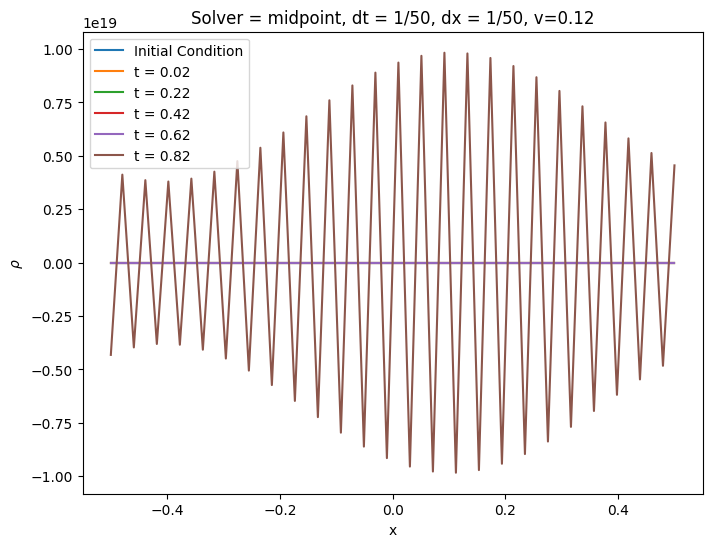

tensor(3.8048e+20)


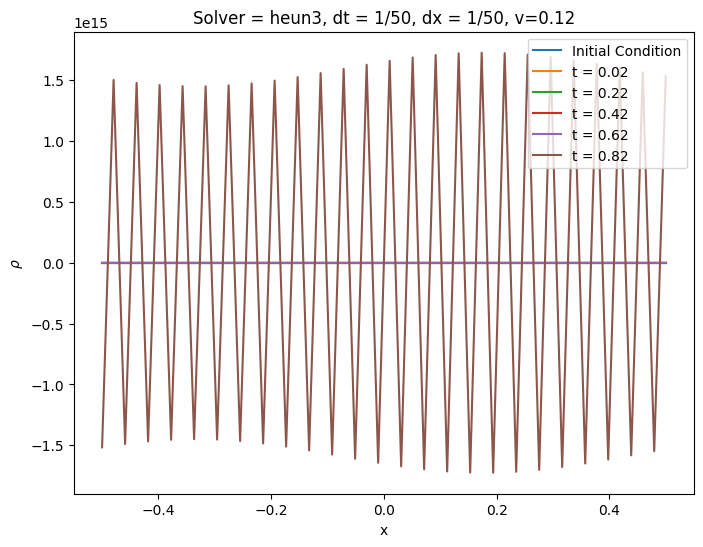

tensor(16.7022)


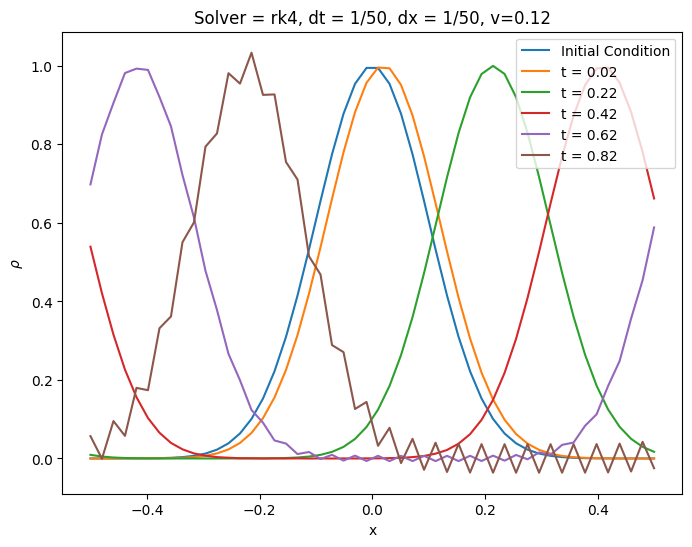

tensor(nan)


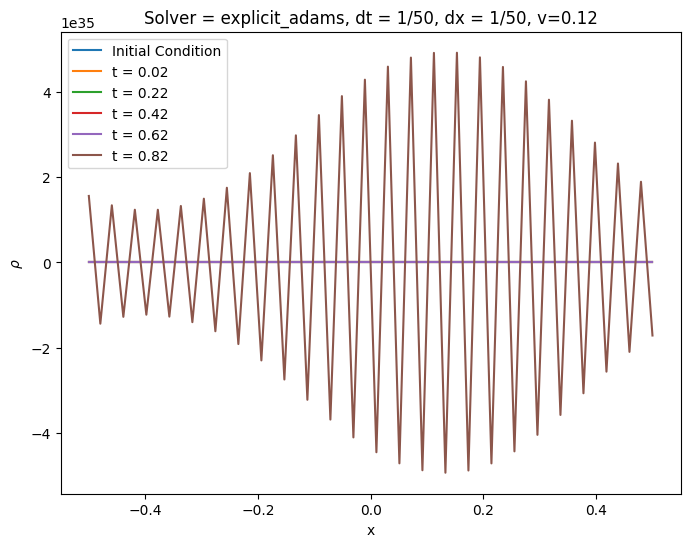

/home/mao1756/.local/lib/python3.8/site-packages/torchdiffeq/_impl/fixed_adams.py:220: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


tensor(nan)


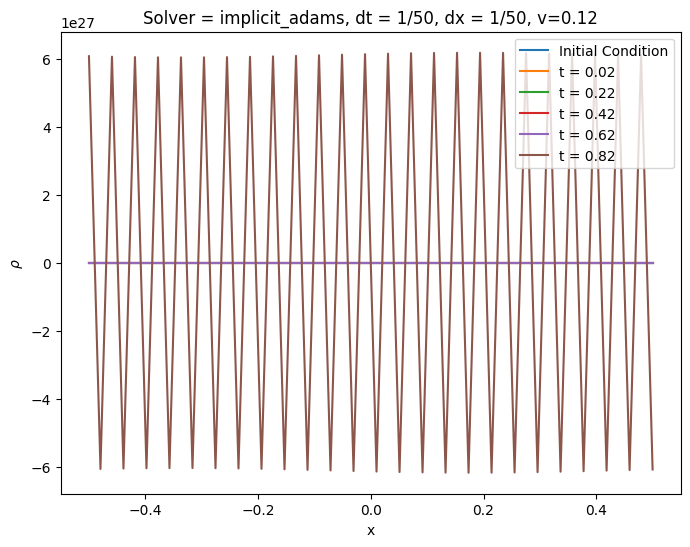

tensor(nan)


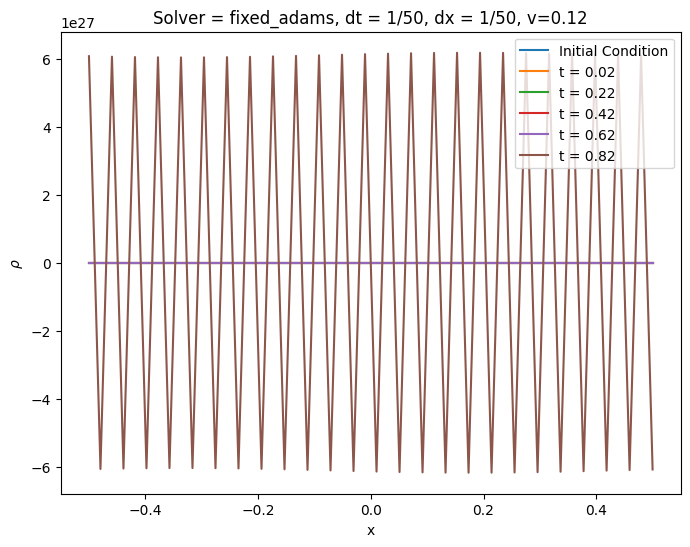

solvers  times (sec)
0           euler     0.267306
1        midpoint     0.327982
2           heun3     0.274239
3             rk4     0.340291
4  explicit_adams     0.149138
5  implicit_adams     0.749991
6     fixed_adams     0.391526

In [93]:
import time
import pandas as pd

def plot_solution(x, p0, preal, cs, velocity, solver):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, p0, label="Initial Condition")
    for i in range(1, cs[0]+1, cs[0]//5):
            ax.plot(x, preal[i], label=f"t = {i/cs[0]:.2f}")
    ax.set_title(f"Solver = {solver}, dt = 1/{cs[0]}, dx = 1/{cs[1]}, v={velocity}")
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\rho$")
    ax.legend()
    plt.show()

# Setting up the problem
cs = [50, 50]  # [time steps, spatial points]
ll = [1.0, 1.0]  # [total time, spatial domain size]
x = torch.linspace(-ll[1]/2, ll[1]/2, cs[1])
size = [cs[0]+1, *cs[1:]]
p0 = torch.exp(-50*x**2)
velocity=6/cs[1]
v = velocity*torch.ones(size+[1])
print(velocity*cs[1]/cs[0])


solvers = [#'dopri8',
 #'dopri5',
 #'bosh3',
 #'fehlberg2',
 #'adaptive_heun',
 'euler',
 'midpoint',
 'heun3',
 'rk4',
 'explicit_adams',
 'implicit_adams',
 'fixed_adams']

times = []

for solver in solvers:
      start_time = time.time()
      ftp =  FourierTransportEquation(
            cs,
            ll,
            p0,
            v,
            solver
      )
      p = ftp.solve()
      end_time = time.time()
      #print(f'time elapsed for {solver}: {end_time-start_time}')
      times.append(end_time-start_time)
      preal = [torch.fft.ifftn(rfftn_recover(p[i], cs[1:])).real for i in range(cs[0]+1)]
      print(preal[-1].max())
      plot_solution(x, p0, preal, cs, velocity, solver)

table = {
      'solvers': solvers,
      'times (sec)' : times 
}
df = pd.DataFrame(table)
df